In [1]:
%matplotlib notebook
%load_ext autoreload

In [2]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr

import torch
import torch.nn.functional as F

import dolfin
import torchfem
import torchfem.materials
import pyvista as pv
pv.set_jupyter_backend('static')
pv.start_xvfb()

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import sys
sys.path.append('..')
import project

# Load lung CT image data

In [3]:
# configuration settings
case_name = 'Case1Pack'
fixed_phase = 0
moving_phase = 10
mask_roi = 'lung_regions'
mesh_radius = 10

In [71]:
images = project.imaging.Emory4DCT(
    data_root='../data/Emory-4DCT',
    case_names=[case_name]
)
images

Emory4DCT('../data/Emory-4DCT', 1 cases)

In [74]:
case = images[0]
case.load_niftis()
case.load_masks(roi='lung_regions')
case.anat

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T10/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T20/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T30/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T40/lung_regions.nii.gz


<xarray.DataArray 'CT' (phase: 10, x: 256, y: 256, z: 94)> Size: 493MB
array([[[[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         ...,
         [ -626.,  -632.,  -680., ...,  -716.,  -664.,  -796.],
         [ -545.,  -551.,  -562., ...,  -388.,  -458.,  -494.],
         [ -399.,  -405.,  -384., ...,  -381.,  -347.,  -422.]],

        [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         ...,
         [ -616.,  -624.,  -670., ...,  -724.,  -672.,  -809.],
         [ -548.,  -533.,  -547., ...,  -380.,  -452.,  -499.],
         [ -402.,  -398.,  -367., ...,  -375.,  -353.,  -414.]],

        [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         ...,
...
         ...,
         [ -597.,  -584.,  -593., ...,  -518.,  -488.,  -539.],
         [ -367.,  -379.,  -408., ...,  -376.,  -424.,  -419.],
         [ -420.,  -408.,  -417., ...,  -689.,  -695.,  -691.]],

        [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         ...,
         [ -584.,  -564.,  -590., ...,  -534.,  -493.,  -540.],
         [ -368.,  -374.,  -393., ...,  -377.,  -422.,  -424.],
         [ -408.,  -393.,  -410., ...,  -688.,  -696.,  -702.]],

        [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         ...,
         [ -593.,  -593.,  -585., ...,  -536.,  -505.,  -539.],
         [ -391.,  -379.,  -385., ...,  -389.,  -445.,  -401.],
         [ -409.,  -410.,  -414., ...,  -695.,  -697.,  -689.]]]])
Coordinates:
  * phase    (phase) int64 80B 0 10 20 30 40 50 60 70 80 90
  * x        (x) float64 2kB 0.0 0.97 1.94 2.91 3.88 ... 244.4 245.4 246.4 247.4
  * y        (y) float64 2kB 0.0 0.97 1.94 2.91 3.88 ... 244.4 245.4 246.4 247.4
  * z        (z) float64 752B 0.0 2.5 5.0 7.5 10.0 ... 225.0 227.5 230.0 232.5

In [75]:
anat = case.anat
mask = case.mask

In [82]:
emph = (mask > 0) * (
    (anat < -900) +
    (anat < -925) +
    (anat < -950)
) + (mask == 0) * -3
emph.name = 'emph'

In [108]:
a = anat.to_dataframe()
m = mask.sel(roi='lung_regions').to_dataframe()

In [116]:
a[m['mask'] > 0]['CT'].describe()

count    9.286841e+06
mean    -7.081262e+02
std      1.461463e+02
min     -1.000000e+03
25%     -7.900000e+02
50%     -7.500000e+02
75%     -6.820000e+02
max      7.010000e+02
Name: CT, dtype: float64

CT


<IPython.core.display.Javascript object>


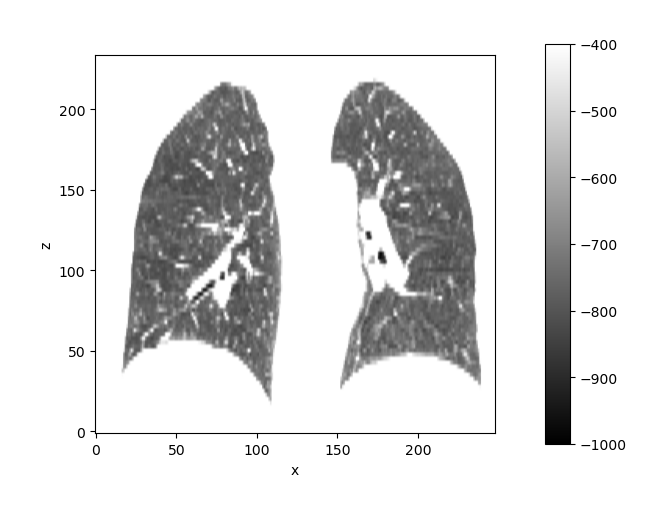

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

emph


<IPython.core.display.Javascript object>


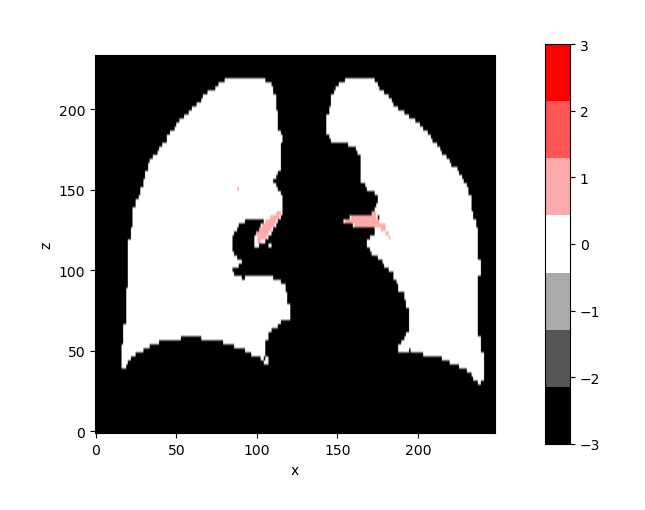

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

In [117]:
project.visual.XArrayViewer(
    anat, y='z',
    vmin=-1000,
    vmax=-400,
).update_index(phase=0, y=150)

project.visual.XArrayViewer(
    emph, y='z'
)

In [ ]:
nodes = torch.as_tensor(mesh.coordinates(), dtype=torch.float32, device='cpu')
elements = torch.as_tensor(mesh.cells(), dtype=torch.long, device='cpu')
nodes.shape, elements.shape

In [ ]:
# orient elements to fix negative Jacobian error
etype = torchfem.elements.Tetra1()

J = etype.B(etype.ipoints()[0]) @ nodes[elements,:]
detJ = torch.linalg.det(J)

for i in range(len(elements)):
    if detJ[i] < 0:
        p0, p1, p2, p3 = elements[i]
        elements[i] = torch.tensor([p0, p1, p3, p2])
        
J = etype.B(etype.ipoints()[0]) @ nodes[elements,:]
detJ = torch.linalg.det(J)
detJ

In [ ]:
%%time
boundary = dolfin.BoundaryMesh(mesh, 'exterior')
on_boundary = boundary.entity_map(0).array()

forces = torch.zeros_like(nodes)

displacements = torch.zeros_like(nodes)
displacements[on_boundary,:] = project.interpolation.interpolate_image(
    image=disp,
    points=nodes[on_boundary,:],
    resolution=resolution,
    radius=mesh_radius,
    sigma=mesh_radius/2
)

constraints = torch.zeros_like(nodes, dtype=bool)
constraints[on_boundary,:] = True

stiffness = torchfem.materials.Isotropic(E=2e3, nu=0.4).C()

In [ ]:
%%time
model = torchfem.Solid(nodes, elements, forces, displacements, constraints, stiffness)
u, f = model.solve()

In [ ]:
def plot(
    self,
    u=0.0,
    node_property=None,
    element_property=None,
    show_edges=True,
    show_undeformed=False,
    contour=None,
):
    try:
        import pyvista
    except ImportError:
        raise Exception("Plotting 3D requires pyvista.")

    pyvista.set_plot_theme("document")
    pl = pyvista.Plotter()
    pl.enable_anti_aliasing("ssaa")

    # VTK cell types
    if isinstance(self.etype, torchfem.elements.Tetra1):
        cell_types = self.n_elem * [pyvista.CellType.TETRA]
    elif isinstance(self.etype, torchfem.elements.Tetra2):
        cell_types = self.n_elem * [pyvista.CellType.QUADRATIC_TETRA]
    elif isinstance(self.etype, torchfem.elements.Hexa1):
        cell_types = self.n_elem * [pyvista.CellType.HEXAHEDRON]
    elif isinstance(self.etype, torchfem.elements.Hexa2):
        cell_types = self.n_elem * [pyvista.CellType.QUADRATIC_HEXAHEDRON]

    # VTK element list
    elements = []
    for element in self.elements:
        elements += [len(element), *element]

    # Deformed node positions
    pos = self.nodes + u

    # Create unstructured mesh
    mesh = pyvista.UnstructuredGrid(elements, cell_types, pos.tolist())

    # Plot node properties
    if node_property:
        for key, val in node_property.items():
            mesh.point_data[key] = val

    # Plot cell properties
    if element_property:
        for key, val in element_property.items():
            mesh.cell_data[key] = val

    if contour:
        mesh = mesh.cell_data_to_point_data()
        mesh = mesh.contour(contour)

    # Trick to plot edges for quadratic elements
    # See: https://github.com/pyvista/pyvista/discussions/5777
    if show_edges:
        surface = mesh.separate_cells().extract_surface(nonlinear_subdivision=4)
        edges = surface.extract_feature_edges()
        pl.add_mesh(surface)
        actor = pl.add_mesh(edges, style="wireframe", color="black", line_width=3)
        actor.mapper.SetResolveCoincidentTopologyToPolygonOffset()
    else:
        pl.add_mesh(mesh)

    if show_undeformed:
        undefo = pyvista.UnstructuredGrid(elements, cell_types, self.nodes.tolist())
        edges = (
            undefo.separate_cells()
            .extract_surface(nonlinear_subdivision=4)
            .extract_feature_edges()
        )
        pl.add_mesh(edges, style="wireframe", color="grey", line_width=1)

    pl.show(jupyter_backend="static")
    
plot(model, u=u, node_property={'Disp': u})

## Physical model

Conservation of momentum
$$
    \nabla\cdot\sigma + \mathbf{b} = 0
$$

Isotropic linear elasticity
$$
    \sigma = 2 \mu \epsilon + \lambda \operatorname{tr}(\epsilon) \mathbf{I}
$$

Strain-displacement relation
$$
    \epsilon = \tfrac{1}{2} \left( \nabla \mathbf{u} + \nabla \mathbf{u}^\top \right)
$$

Weak formulation
$$
\begin{align*}
    \nabla\cdot\sigma + \mathbf{b} &= 0 \\
    -\nabla\cdot\sigma &= \mathbf{b} \\
    -\int_\Omega (\nabla\cdot\sigma)\cdot\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} \\
    \int_\Omega \sigma\cdot\nabla\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} (\sigma\cdot\mathbf{n})\cdot\mathbf{v} \,d\mathbf{s} \\
    \int_\Omega \sigma(\mathbf{u})\cdot\epsilon(\mathbf{v}) \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} \mathbf{t}\cdot\mathbf{v} \,d\mathbf{s}
\end{align*}
$$



In [ ]:
%%time
class PDESolver(torch_fenics.FEniCSModule):

    def __init__(self, mesh):
        super().__init__()
        
        # initialize function spaces
        self.scalar_space = fe.FunctionSpace(mesh, 'P', 1)
        self.vector_space = fe.VectorFunctionSpace(mesh, 'P', 1)
            
    def input_templates(self):
        return (
            fa.Function(self.vector_space), # u_true
            fa.Function(self.scalar_space), # mu
            fa.Function(self.scalar_space), # rho
        )

    def solve(self, u_true, mu, rho):

        # define physical parameters
        g   = 9.8 # gravitational acceleration (m/s^2)
        nu  = 0.4 # Poisson's ratio (unitless)
    
        lam = 2*mu*nu/(1 - 2*nu) # Lame's first parameter (Pa)

        # set displacement boundary condition
        u_bc = fa.DirichletBC(self.vector_space, u_true, 'on_boundary')

        # body force and traction
        b = fe.as_vector([-rho * g / 1000, 0, 0]) # m -> mm
        t = fa.Constant([0, 0, 0])

        # define stress and strain
        def epsilon(u):
            return (fe.grad(u) + fe.grad(u).T) / 2

        def sigma(u):
            I = fe.Identity(u.geometric_dimension())
            return lam * fe.div(u) * I + 2 * mu * epsilon(u)

        # weak PDE formulation
        u = fe.TrialFunction(self.vector_space)
        v = fe.TestFunction(self.vector_space)

        a = fe.inner(sigma(u), epsilon(v)) * fe.dx
        L = fe.dot(b, v) * fe.dx + fe.dot(t, v) * fe.ds

        # solve for displacement
        u_pred = fa.Function(self.vector_space)
        fa.solve(a == L, u_pred, u_bc)

        return u_pred

pde_solver = PDESolver(ee_lung_fe_mesh)

u_tensor = torch.as_tensor(reg_disp_image.values)
mu_tensor = torch.ones(case.shape, dtype=torch.float64) * 3e3
rho_tensor = torch.as_tensor(ee_rho_image.values, dtype=torch.float64)

u_func_dofs = project.interpolate.image_to_dofs(u_tensor, case.resolution, pde_solver.vector_space)
u_func_dofs.requires_grad = False

mu_func_dofs = project.interpolate.image_to_dofs(mu_tensor, case.resolution, pde_solver.scalar_space)
mu_func_dofs.requires_grad = True

rho_func_dofs = project.interpolate.image_to_dofs(rho_tensor, case.resolution, pde_solver.scalar_space)
rho_func_dofs.requires_grad = False

u_pred_func_dofs = pde_solver.forward(
    u_func_dofs.unsqueeze(0), mu_func_dofs.unsqueeze(0), rho_func_dofs.unsqueeze(0)
)[0]

In [ ]:
# compute PDE-constrained loss and mu sensitivity

L = F.mse_loss(u_pred_func_dofs, u_func_dofs)
print(L)
L.backward()
print(u_func_dofs.grad)
print(mu_func_dofs.grad)

In [ ]:
# PDE-constrained optimization

def relative_error(u_pred, u_true):
    u_diff = u_pred - u_true
    u_diff_norm2 = (u_diff**2).sum(axis=-1)
    u_true_norm2 = (u_true**2).sum(axis=-1)
    return torch.mean(u_diff_norm2 / u_true_norm2)

mu_func_dofs.requires_grad = True
optimizer = torch.optim.Adam([mu_func_dofs], lr=1e1)

for i in range(1000):
    optimizer.zero_grad()

    u_pred_func_dofs = pde_solver.forward(
        u_func_dofs.unsqueeze(0), mu_func_dofs.unsqueeze(0), rho_func_dofs.unsqueeze(0)
    )[0]

    loss = relative_error(u_pred_func_dofs, u_func_dofs)
    print((i+1), loss.item())

    loss.backward()
    optimizer.step()


In [ ]:
%%time
u_pred_image = project.interpolate.dofs_to_image(u_pred_func_dofs, pde_solver.vector_space, case.shape, case.resolution)

In [ ]:
%%time
mu_pred_image = project.interpolate.dofs_to_image(mu_func_dofs, pde_solver.scalar_space, case.shape, case.resolution)

In [ ]:
project.visual.XArrayViewer((reg_disp_image * 0 + u_pred_image) * ee_lung_mask, x='x', y='z').update_index(y=140, component=2)
project.visual.XArrayViewer(reg_disp_image * ee_lung_mask, x='x', y='z').update_index(y=140, component=2)
project.visual.XArrayViewer(mu_pred_image * ee_lung_mask, x='x', y='z', cmap=project.visual.mre_color_map(), vmin=-2e4, vmax=2e4).update_index(y=140)

In [ ]:
def estimate_limit(x, expand=0.1):
    x_min, x_max = np.min(x), np.max(x)
    x_range = (x_max - x_min)
    x_min -= expand * x_range / 2
    x_max += expand * x_range / 2
    return x_min, x_max

def plot_func(f):

    mesh = f.function_space().mesh()

    vertices = mesh.coordinates()
    n_vertices = mesh.num_vertices()
    values = f.compute_vertex_values(mesh)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d', aspect='equal')

    X = [vertices[:,i] for i in range(3)]
    U = [values[i * n_vertices:(i + 1) * n_vertices] for i in range(3)]
    
    print(np.mean(np.linalg.norm(U, axis=1), axis=0))
       
    args = X + U
    ax.quiver(*args)
    
    ax.set_xlim(estimate_limit(vertices.flatten()))
    ax.set_ylim(estimate_limit(vertices.flatten()))
    ax.set_zlim(estimate_limit(vertices.flatten()))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig, ax

plot_func(disp_fe_func)

In [ ]:
project.visual.view((reg_disp_image * 0 + sim_disp_image) * ee_lung_mask, x='x', y='z')